In [1]:
%matplotlib inline

from sqlalchemy import create_engine
import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as col
from matplotlib.dates import  DateFormatter
import seaborn as sns

import config
import db_service

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

sns.set_style("whitegrid")
sns.set_context("poster")

from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV


np.set_printoptions(precision=3,suppress=True)

In [26]:
### Call this method to retrieve the data directly from DB :

# db_service.create_counts_sites_weather_holidays()

### Otherwise load the file :
df = pd.read_csv('data/counts_sites_weather_holidays.csv',parse_dates=['timestamp_hour'],index_col=0)


COLUMNS_FOR_REG = ['temperature','cloudamount_x','weathersituation_x','maxtemperature','mintemperature']

COLUMNS_X = ['index','idbldsite' ,'is_holiday','hour','day_of_week','month']+[col+"_reg" for col in COLUMNS_FOR_REG]
COLUMNS_Y = ['index','idbldsite', 'compensatedin']


dataset_past_dict = {}
dataset_forecasts_dict ={}
dataset_forecasting_dict = {}


### Data preparation

In [27]:
### From the count_weather_holidays data, generate a prediction and a target set.
### It is important to keep the index of the data with both X and Y to check the validty of predictions.

def regularize_dataset(df):
    df = df.reset_index()
    df.set_index(['idbldsite','index'])
    groupy = df.groupby('idbldsite')
    
    data = df.copy()


    for col in COLUMNS_FOR_REG:
        data[col+"_reg"] = data.groupby('idbldsite')[col].transform(lambda x: (x - x.mean()) / x.std())

    data = data.fillna(0)
    return data


def create_predictors_and_target(dataset_reg,dataset_dict,forecasting=False):
    for name,group in dataset_reg.groupby('idbldsite'):
        dataset_dict[name]={'X' :group[COLUMNS_X],
                            'mean':group.mean(),'std':group.std()}
        if forecasting:
            dataset_dict[name]['timestamp_hour'] = group['timestamp_hour']
        else:
            dataset_dict[name]['y'] = group[COLUMNS_Y]
        
def regularize(title,temp,idbldsite):
    mean =  dataset_past_dict[idbldsite]['mean'][title]
    std =  dataset_past_dict[idbldsite]['std'][title]
    return (temp-mean)/std
    
    
def regularize_forecast(df_forecast):
    df_forecast = df_forecast.reset_index()
    for col in COLUMNS_FOR_REG:
       
        df_forecast[col+'_reg'] = df_forecast.apply(lambda x : regularize(col,x.temperature,x.idbldsite),axis=1)
   
    return df_forecast
        

In [28]:
def create_forecasting_data(date_from,date_to):
    df_forecasting = pd.DataFrame()
    df_sites = db_service.get_sites()
    sites_id = df_sites.idbldsite.unique()
    for site_id in sites_id:
        
        df_forecasting_site =  pd.DataFrame(pd.date_range(date_from,date_to,freq='6H'),columns=['timestamp_hour'])
        df_forecasting_site['idbldsite']=site_id
        df_forecasting_site['hour'] = df_forecasting_site.timestamp_hour.dt.hour
        df_forecasting_site['day_of_week'] = df_forecasting_site.timestamp_hour.dt.dayofweek
        df_forecasting_site['month'] = df_forecasting_site.timestamp_hour.dt.month
        df_forecasting_site =  df_forecasting_site.reset_index()
        df_forecasting_site['is_holiday'] = 3
      
        for col in ['temperature_reg', 'cloudamount_x_reg', 'weathersituation_x_reg', 'maxtemperature_reg', 'mintemperature_reg']:
            df_forecasting_site[col] = pd.Series(np.random.normal(0, 3, df_forecasting_site.shape[0]))
            
        df_forecasting = pd.concat([df_forecasting,df_forecasting_site],axis=0)
        
    create_predictors_and_target(df_forecasting,dataset_forecasting_dict, forecasting=True)
    return df_forecasting

In [29]:
df_forecasting = create_forecasting_data(datetime.date(2016,10,2),datetime.date(2016,10,10))

In [30]:
df_past = df[df.timestamp_hour.dt.date<datetime.date(2016,9,1)]
df_forecasts = df[df.timestamp_hour.dt.date>=datetime.date(2016,10,2)]


In [31]:
df_past.head()

,idbldsite,compensatedin,timestamp_hour,temperature,cloudamount_x,weathersituation_x,maxtemperature,mintemperature,sname,is_holiday,day_of_week,month,hour
14063,1,609,2014-06-17 15:00:00,23.6,0.0,NaN,23.6,11.4,Sierre,0,1,6,15
14065,1,657,2014-06-17 17:00:00,18.0,8.0,NaN,23.6,11.4,Sierre,0,1,6,17
14067,1,6,2014-06-17 19:00:00,17.0,7.0,NaN,23.6,11.4,Sierre,0,1,6,19
14069,1,0,2014-06-17 21:00:00,15.7,5.0,NaN,23.6,11.4,Sierre,0,1,6,21
14071,1,0,2014-06-17 23:00:00,13.8,0.0,NaN,23.6,11.4,Sierre,0,1,6,23


In [32]:
data_past_reg = regularize_dataset(df_past)
create_predictors_and_target(data_past_reg,dataset_past_dict)

data_forecasts_reg = regularize_forecast(df_forecasts)
create_predictors_and_target(data_forecasts_reg, dataset_forecasts_dict)

In [33]:
site = 14

In [34]:
X = dataset_past_dict[site]['X'].values
y = dataset_past_dict[site]['y'].values

X_forecast = dataset_forecasts_dict[site]['X'].values
y_forecast = dataset_forecasts_dict[site]['y'].values

### Pipeline

In [35]:
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

In [36]:
def do_classify(clf, parameters, X,y, mask=None, score_func=None, n_folds=5, n_jobs=1):
    # remove index and idbldsite
    X,y = X[:,2:],y[:,2:].ravel()
    Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.25)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print "########################################################"
    try:
        print clf.feature_importances_
    except :
        print "no feature_importance"
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

#### RandomForestRegressor

In [37]:
params = { 'n_estimators':[20,30,50],'bootstrap':[True], 'criterion':['mse']}

In [38]:
clf_rdm = RandomForestRegressor()

In [39]:
clf_rdm, Xtrain, ytrain, Xtest, ytest = do_classify(clf_rdm,params,X,y)

BEST {'n_estimators': 50, 'bootstrap': True, 'criterion': 'mse'} 0.660989781009 [mean: 0.64948, std: 0.03887, params: {'n_estimators': 20, 'bootstrap': True, 'criterion': 'mse'}, mean: 0.65404, std: 0.03292, params: {'n_estimators': 30, 'bootstrap': True, 'criterion': 'mse'}, mean: 0.66099, std: 0.04219, params: {'n_estimators': 50, 'bootstrap': True, 'criterion': 'mse'}]
############# based on standard predict ################
Accuracy on training data: 0.95
Accuracy on test data:     0.69
########################################################
[ 0.     0.272  0.193  0.109  0.084  0.04   0.049  0.082  0.172]
########################################################


#### BayesianRidge


In [40]:
clf_br = linear_model.BayesianRidge(compute_score=True,normalize=True)
clf_br.fit(Xtrain,ytrain)
print clf_br.score(Xtest,ytest)
clf_br


0.10929702467


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=True, tol=0.001, verbose=False)

#### Linear regression

In [41]:
clf_lr = LinearRegression()
clf_lr.fit(Xtrain,ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### Lasso

In [42]:
clf_lasso = linear_model.Lasso(alpha=0.1)
params = {'alpha': [0.000001,0.0001,0.001,0.01,0.1,1,10]}
clf_lasso, Xtrain, ytrain, Xtest, ytest = do_classify(clf_lasso,params,X,y)

BEST {'alpha': 0.001} 0.10907213352 [mean: 0.10907, std: 0.01803, params: {'alpha': 1e-06}, mean: 0.10907, std: 0.01803, params: {'alpha': 0.0001}, mean: 0.10907, std: 0.01803, params: {'alpha': 0.001}, mean: 0.10857, std: 0.01788, params: {'alpha': 0.01}, mean: 0.10382, std: 0.01571, params: {'alpha': 0.1}, mean: 0.02446, std: 0.00650, params: {'alpha': 1}, mean: -0.00324, std: 0.00319, params: {'alpha': 10}]
############# based on standard predict ################
Accuracy on training data: 0.11
Accuracy on test data:     0.11
########################################################
no feature_importance
########################################################


#### SGD Regressor

In [43]:
clf_sgd = linear_model.SGDRegressor()
params = {'alpha':[0.0001,0.0001,0.001,0.01,0.1,1,10]}
clf_sgd, Xtrain, ytrain, Xtest, ytest = do_classify(clf_lasso,params,X,y)

BEST {'alpha': 0.001} 0.107864895757 [mean: 0.10786, std: 0.01682, params: {'alpha': 0.0001}, mean: 0.10786, std: 0.01682, params: {'alpha': 0.0001}, mean: 0.10786, std: 0.01676, params: {'alpha': 0.001}, mean: 0.10736, std: 0.01594, params: {'alpha': 0.01}, mean: 0.10351, std: 0.01297, params: {'alpha': 0.1}, mean: 0.02771, std: 0.00600, params: {'alpha': 1}, mean: -0.00033, std: 0.00018, params: {'alpha': 10}]
############# based on standard predict ################
Accuracy on training data: 0.11
Accuracy on test data:     0.12
########################################################
no feature_importance
########################################################


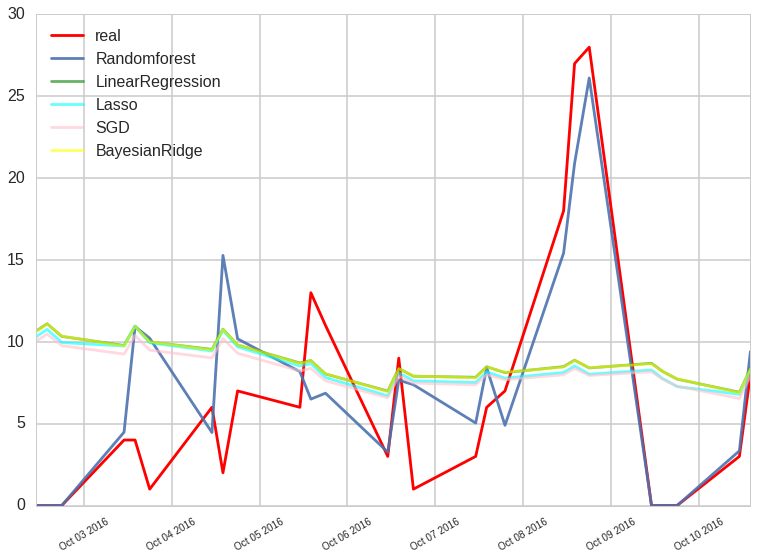

In [44]:
fig, ax = plt.subplots()
plt.plot(df_forecasts[df_forecasts.idbldsite==site].timestamp_hour.values,y_forecast[:,2:],alpha=1,color='r')
plt.plot(df_forecasts[df_forecasts.idbldsite==site].timestamp_hour.values,(clf_rdm.predict(X_forecast[:,2:])),alpha=0.9)
plt.plot(df_forecasts[df_forecasts.idbldsite==site].timestamp_hour.values,(clf_lr.predict(X_forecast[:,2:])),alpha=0.6,color='g')
plt.plot(df_forecasts[df_forecasts.idbldsite==site].timestamp_hour.values,(clf_lasso.predict(X_forecast[:,2:])),alpha=0.6,color='cyan')
plt.plot(df_forecasts[df_forecasts.idbldsite==site].timestamp_hour.values,(clf_sgd.predict(X_forecast[:,2:])),alpha=0.6,color='pink')
plt.plot(df_forecasts[df_forecasts.idbldsite==site].timestamp_hour.values,(clf_br.predict(X_forecast[:,2:])),alpha=0.6,color='yellow')
labels = ax.get_xticklabels()
plt.setp(labels, rotation=30, fontsize=10)
ax.legend(['real','Randomforest','LinearRegression','Lasso','SGD','BayesianRidge'],loc=0)


In [45]:
X_forecasting = dataset_forecasting_dict[1]['X'].values
pd.DataFrame(X_forecasting).head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.0,1.0,3.0,0.0,6.0,10.0,-1.406240,-3.782518,-0.225994,-0.530508,1.624748
1,1.0,1.0,3.0,6.0,6.0,10.0,1.369685,1.853597,-4.895921,-3.094837,-0.924424
2,2.0,1.0,3.0,12.0,6.0,10.0,2.856211,0.840553,4.490696,-0.695181,-3.658630
3,3.0,1.0,3.0,18.0,6.0,10.0,-6.438553,1.835483,0.372178,2.125399,0.224688
4,4.0,1.0,3.0,0.0,0.0,10.0,3.812415,2.106305,0.301166,-4.543372,2.048736


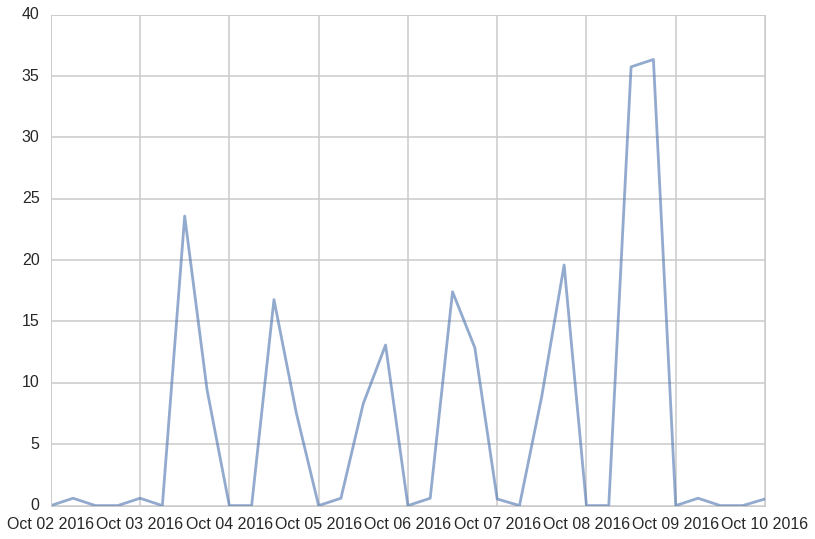

In [46]:

plt.plot(dataset_forecasting_dict[14]['timestamp_hour'].values,(clf_rdm.predict(X_forecasting[:,2:])),alpha=0.6)

In [47]:
df_intraday = db_service.get_weather_intraday()

In [48]:
pd.DataFrame(pd.date_range(datetime.datetime(2016,10,13,8),datetime.datetime(2016,10,15,18),freq='6H',closed='left'),columns=['timestamp_hour'])

,timestamp_hour
0,2016-10-13 08:00:00
1,2016-10-13 14:00:00
2,2016-10-13 20:00:00
3,2016-10-14 02:00:00
4,2016-10-14 08:00:00
5,2016-10-14 14:00:00
6,2016-10-14 20:00:00
7,2016-10-15 02:00:00
8,2016-10-15 08:00:00
9,2016-10-15 14:00:00
